# 네이버 영화리뷰 감성 분석

## 데이터 불러오기

In [1]:
import pandas as pd
import konlpy
import gensim
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [7]:
# decoding
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 모델 구성을 위한 데이터 분석 및 가공

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


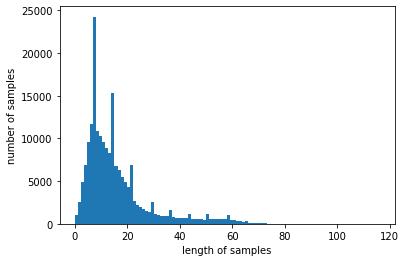

In [8]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(X_train) + list(X_test)

# 문장길이의 평균값, 최대값, 표준편차를 계산
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
plt.clf()

plt.hist([len(s) for s in total_data_text], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 가정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# padding
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 
(146182, 41)


## 모델 구성 및 validation set 구성

### RNN

In [10]:
vocab_size = 10000    
word_vector_dim = 16  

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 모델 훈련 개시

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.5145 - accuracy: 0.7792 - val_loss: 0.3662 - val_accuracy: 0.8480
Epoch 2/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3442 - accuracy: 0.8565 - val_loss: 0.3435 - val_accuracy: 0.8511
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3195 - accuracy: 0.8676 - val_loss: 0.3388 - val_accuracy: 0.8527
Epoch 4/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3063 - accuracy: 0.8741 - val_loss: 0.3380 - val_accuracy: 0.8559
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2958 - accuracy: 0.8782 - val_loss: 0.3402 - val_accuracy: 0.8552
Epoch 6/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2843 - accuracy: 0.8843 - val_loss: 0.3349 - val_accuracy: 0.8574
Epoch 7/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2740 - accuracy: 0.8888 - val_loss: 0.3383 - val_accuracy: 0.8579
Epoch 

In [13]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4681 - accuracy: 0.8401
[0.4681423604488373, 0.8400634527206421]


##  Loss, Accuracy 그래프 시각화

In [14]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


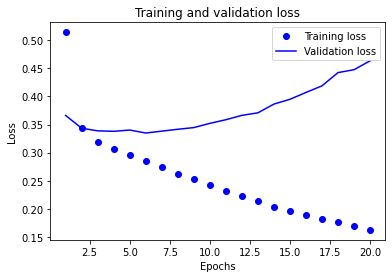

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

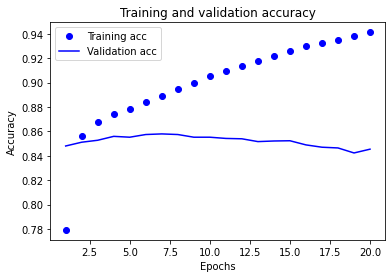

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [18]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([-0.16341214,  0.25358456,  0.09993762, -0.10953399, -0.1418832 ,
       -0.18172915,  0.34910738,  0.01093491,  0.07972146,  0.07633276,
       -0.11970273, -0.1387946 ,  0.02778493, -0.06655012,  0.00414526,
        0.14189176], dtype=float32)

In [21]:
word_vectors.similar_by_word("감동")

[('브라이언', 0.9553638100624084),
 ('토이', 0.9360745549201965),
 ('따듯', 0.935374915599823),
 ('룬드그렌', 0.9312060475349426),
 ('정화', 0.9299777746200562),
 ('니콜슨', 0.9297392964363098),
 ('훌륭', 0.9256105422973633),
 ('맷데이먼', 0.925228476524353),
 ('하이라이트', 0.9203944802284241),
 ('중후', 0.9185128211975098)]

### 1-D CNN

In [22]:
vocab_size = 10000 
word_vector_dim = 16  

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.4766 - accuracy: 0.7675 - val_loss: 0.3491 - val_accuracy: 0.8495
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3238 - accuracy: 0.8617 - val_loss: 0.3311 - val_accuracy: 0.8565
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2922 - accuracy: 0.8780 - val_loss: 0.3298 - val_accuracy: 0.8584
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2646 - accuracy: 0.8926 - val_loss: 0.3350 - val_accuracy: 0.8562
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2364 - accuracy: 0.9063 - val_loss: 0.3427 - val_accuracy: 0.8559
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2059 - accuracy: 0.9208 - val_loss: 0.3719 - val_accuracy: 0.8498
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1754 - accuracy: 0.9352 - val_loss: 0.3966 - val_accuracy: 0.8478
Epoch 

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9296 - accuracy: 0.8171
[0.9296383261680603, 0.8170555830001831]


In [26]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


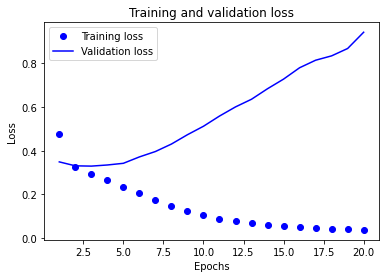

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

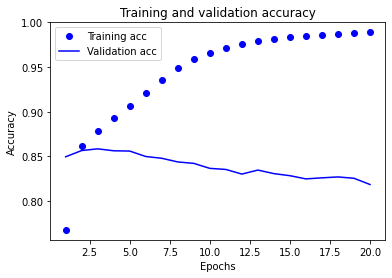

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [30]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector
word_vectors.similar_by_word("감동")

[('학도', 0.8719004392623901),
 ('토요일', 0.8610818982124329),
 ('제주도', 0.8429750800132751),
 ('빙판', 0.8340803384780884),
 ('경', 0.8319981694221497),
 ('여신', 0.8314439058303833),
 ('원조', 0.8305243253707886),
 ('정우', 0.8245620131492615),
 ('경고', 0.8214185833930969),
 ('펼쳐지', 0.8176562786102295)]

###  GlobalMaxPooling1D 모델

In [32]:
vocab_size = 10000  
word_vector_dim = 16 

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [33]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.5894 - accuracy: 0.7237 - val_loss: 0.4530 - val_accuracy: 0.8227
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3909 - accuracy: 0.8396 - val_loss: 0.3627 - val_accuracy: 0.8400
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3311 - accuracy: 0.8614 - val_loss: 0.3464 - val_accuracy: 0.8466
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3027 - accuracy: 0.8751 - val_loss: 0.3438 - val_accuracy: 0.8491
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2823 - accuracy: 0.8850 - val_loss: 0.3461 - val_accuracy: 0.8500
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2659 - accuracy: 0.8926 - val_loss: 0.3495 - val_accuracy: 0.8508
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2524 - accuracy: 0.8995 - val_loss: 0.3577 - val_accuracy: 0.8496
Epoch 

In [35]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5232 - accuracy: 0.8257
[0.5232423543930054, 0.8257012963294983]


In [36]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


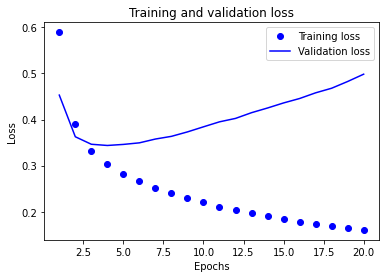

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

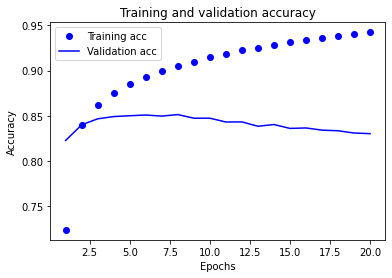

In [38]:

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [39]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [40]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [41]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector
word_vectors.similar_by_word("감동")

[('파격', 0.8651764988899231),
 ('!!!', 0.8551351428031921),
 ('<', 0.8431950211524963),
 ('공감', 0.8258118629455566),
 ('님', 0.8248700499534607),
 ('^^', 0.8152307868003845),
 ('시점', 0.8139114379882812),
 ('환상', 0.8115725517272949),
 ('들어가', 0.8104193210601807),
 ('of', 0.8075770139694214)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [42]:
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec.wv.most_similar("감동")

In [43]:
vector

[('감격', 0.8046045899391174),
 ('감탄', 0.7326707243919373),
 ('매혹', 0.7267226576805115),
 ('매력', 0.7088802456855774),
 ('감명', 0.7069407105445862),
 ('웃음', 0.7015025615692139),
 ('열정', 0.6936471462249756),
 ('칭찬', 0.6831857562065125),
 ('실망', 0.6779423952102661),
 ('슬픔', 0.6770600080490112)]

In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

In [45]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,220,689
Trainable params: 3,220,689
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
2128/2128 [==============================] - 16s 7ms/step - loss: 0.3613 - accuracy: 0.8379 - val_loss: 0.3114 - val_accuracy: 0.8640
Epoch 2/7
2128/2128 [==============================] - 14s 7ms/step - loss: 0.2761 - accuracy: 0.8830 - val_loss: 0.3053 - val_accuracy: 0.8685
Epoch 3/7
2128/2128 [==============================] - 14s 7ms/step - loss: 0.2305 - accuracy: 0.9043 - val_loss: 0.3235 - val_accuracy: 0.8687
Epoch 4/7
2128/2128 [==============================] - 14s 7ms/step - loss: 0.1882 - accuracy: 0.9236 - val_loss: 0.3329 - val_accuracy: 0.8650
Epoch 5/7
2128/2128 [==============================] - 14s 7ms/step - loss: 0.1501 - accuracy: 0.9397 - val_loss: 0.3907 - val_accuracy: 0.8644
Epoch 6/7
2128/2128 [==============================] - 14s 7ms/step - loss: 0.1193 - accuracy: 0.9524 - val_loss: 0.5086 - val_accuracy: 0.8568
Epoch 7/7
2128/2128 [==============================] - 14s 7ms/step - loss: 0.0931 - accuracy: 0.9627 - val_loss: 0.5536 - val_accuracy:

In [47]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


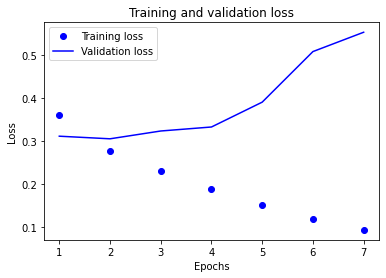

In [48]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

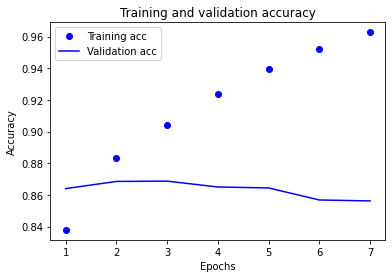

In [49]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [50]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5582 - accuracy: 0.8515
[0.5582148432731628, 0.8515369296073914]


## 회고

RNN 모델 : 0.8401
    
1-D Convolution Neural Network(1-D CNN)모델 : 0.8171
    
GlobalMaxPooling1D() : 0.8257
    
3가지 모델 중 가장 성능이 좋은 모델은 RNN모델이었다. 거의 85%에 가까운 정확도를 보여주었다.




한국어 Word2Vec을 활용한 LSTM 모델을 사용했는데

85% 이상의 정확도를 보여주기 위해

LSTM 값을 올리거나 epoch수, batch size등 다양한 시도를 하였다.

지금까지 했던 Exploration중에 캐글경진대회 11만점 미만 이후로 제일 어렵고 시간 소요가 많았다.

NLP쪽에 관심이 많아서 열심히 공부하고 있지만 점점 진도가 느려지는게 느껴진다.

천천히 급하게 하지말고 정진해가야겠다.